# AGRUPAMIENTO

Entrenamiento de tres elgoritmos de agrupamiento: K-means, DBSCAN y hierarchical clustering a partir de la base de datos preprocesada.

# Carga de las bibliotecas y los datos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy  as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("../Data/escalados.csv", sep=',', index_col='CUST_ID')

## PCA

Debido a que el conjunto de datos incluye 18 variables, se aplicó Análisis de Componentes Principales (PCA) para reducir la dimensionalidad. En este caso, se seleccionaron 10 componentes principales, suficientes para explicar al menos el 90% de la varianza total.

In [4]:
pca = PCA(n_components=0.90)
pca_dec = pca.fit_transform(df)
df_pca = pd.DataFrame(pca_dec, index=df.index)
df_pca

,0,1,2,3,4,5,6,7,8,9
CUST_ID,,,,,,,,,,
C10001,-1.682790,-1.072237,-0.481032,0.678222,-0.070041,-0.094361,-0.814603,-0.023069,0.124406,0.078016
C10002,-1.135173,2.509136,-0.600276,-0.118135,-0.734745,1.055445,0.382189,0.226745,0.658319,0.777445
C10003,0.969935,-0.381975,-0.089117,1.298313,2.129296,0.484503,1.505447,-0.294027,-0.841353,0.002044
C10004,-0.890720,-0.002511,-1.519199,1.044694,-0.254677,0.148648,0.250745,-0.701858,-0.013679,-0.394427
C10005,-1.599314,-0.683573,-0.352489,1.028999,0.415949,-0.072149,-0.697600,0.265679,0.568579,0.121670
...,...,...,...,...,...,...,...,...,...,...
C19186,-0.361185,-2.012373,0.992000,-2.772509,0.157052,-2.621905,1.595929,0.433571,1.314384,0.844453
C19187,-0.586411,-1.693104,1.208769,-2.042609,0.393992,-3.245309,1.112235,-0.570134,0.979141,1.243804
C19188,-0.927821,-1.807708,0.468824,-2.336899,0.051768,-2.948058,1.454083,-0.164902,0.786480,0.829500


## Agrupamiento con Kmeans

> El agrupamiento con K-means requiere que el usuario defina a priori el número de clusters. Por ello se realizó el agrupamiento para identificar de 2 a 10 clusters y el número óptimo se definió con base en el método de codo y el coeficiente de silueta.

In [5]:
def kmeans_clus(data):

    inertia = []
    silhouette_k = []
    
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i,  n_init=20, random_state=666)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
        kmeans.predict(data)
        silhouette_k.append(silhouette_score(data, kmeans.labels_))   
    return inertia, silhouette_k

inertia, silhouette_k = kmeans_clus(df_pca)

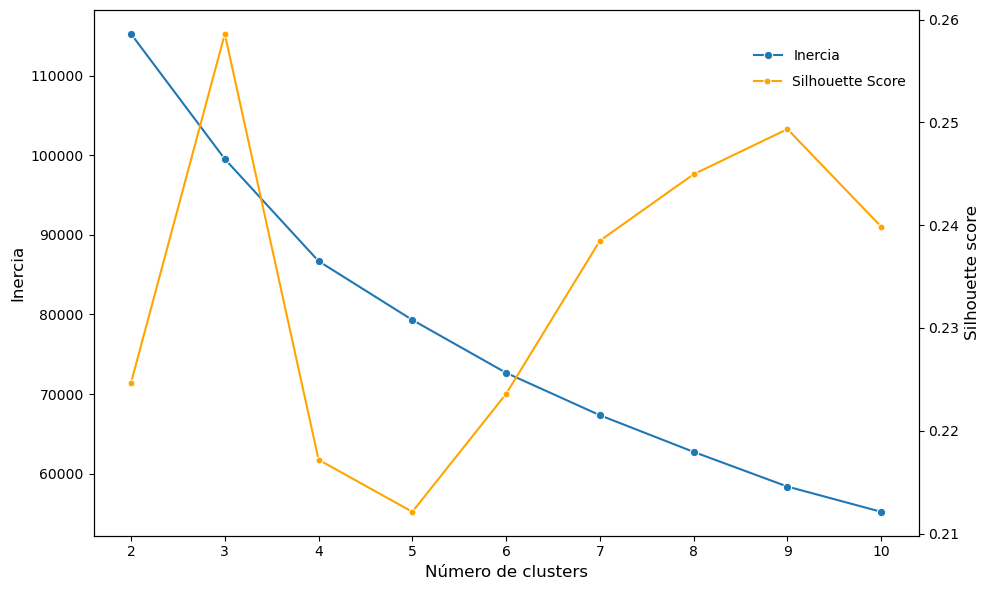

In [6]:
plt.figure(figsize=(10, 6))
a = sns.lineplot(x=range(2, 11), y=inertia, marker='o')
a.legend(['Inercia'],bbox_to_anchor=(0.92,0.95),frameon=False)
plt.ylabel("Inercia", fontsize=12, )
plt.xlabel("Número de clusters", fontsize=12)

ax2 = plt.twinx()
sns.lineplot(x=range(2, 11), y=silhouette_k,  marker='o',  markersize=5,  color="orange", ax=ax2)
plt.ylabel("Silhouette score", fontsize=12)
ax2.legend(['Silhouette Score'],bbox_to_anchor=(1,0.9),frameon=False)

plt.tight_layout()
plt.show()

En la gráfica de número de clusters vs. inercia, no se observa un punto claro donde agregar más clusters deje de mejorar significativamente la compactación de los datos. Por esta razón, el método del codo no resulta informativo en este caso. Sin embargo, al analizar el coeficiente de silueta, se identificó que este alcanza su valor máximo con 3 clusters. Por lo tanto, se decidió entrenar el modelo de K-Means utilizando tres clusters.

In [7]:
kmeans = KMeans(n_clusters=3,  n_init=20, random_state=666)
kmeans.fit_predict(df_pca)

array([0, 2, 0, ..., 0, 0, 0], dtype=int32)

# Agrupamiento con DBSCAN

> Para realizar el agrupamiento con DBSCAN se ajustaron los valores de dos parametos: eps (radio de la vecindad) y min_samples (número mínimo de puntos en la vecindad para que un punto sea considerado "núcleo").

In [8]:
def dbscan_clus(data):
    silhouette_dbscan = []
    num_clusters = []
    index_n = pd.DataFrame(columns=['eps', 'min_samples'])

    for i in np.linspace(0.5,2,4):
        for j in (5, 10, 15):
            obj_dbscan = DBSCAN(eps=i, min_samples=j)
            labels = obj_dbscan.fit_predict(data)
            silhouette_dbscan.append(silhouette_score(data, obj_dbscan.labels_))
            unique_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            num_clusters.append(unique_clusters)
            new_row = pd.DataFrame({'eps': [i], 'min_samples': [j]})
            index_n = pd.concat([index_n, new_row], ignore_index=True)

    return silhouette_dbscan, index_n,  num_clusters

silhouette_dbscan, index_n,  num_clusters  = dbscan_clus(df_pca)

/tmp/ipykernel_7547/3638648846.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  index_n = pd.concat([index_n, new_row], ignore_index=True)


In [9]:
index_n['silouethe_dbscan'] = silhouette_dbscan
index_n['num_clusters'] = num_clusters
index_n['eps/min_samples'] = index_n['eps'].astype(str) + "/" + index_n['min_samples'].astype(str)

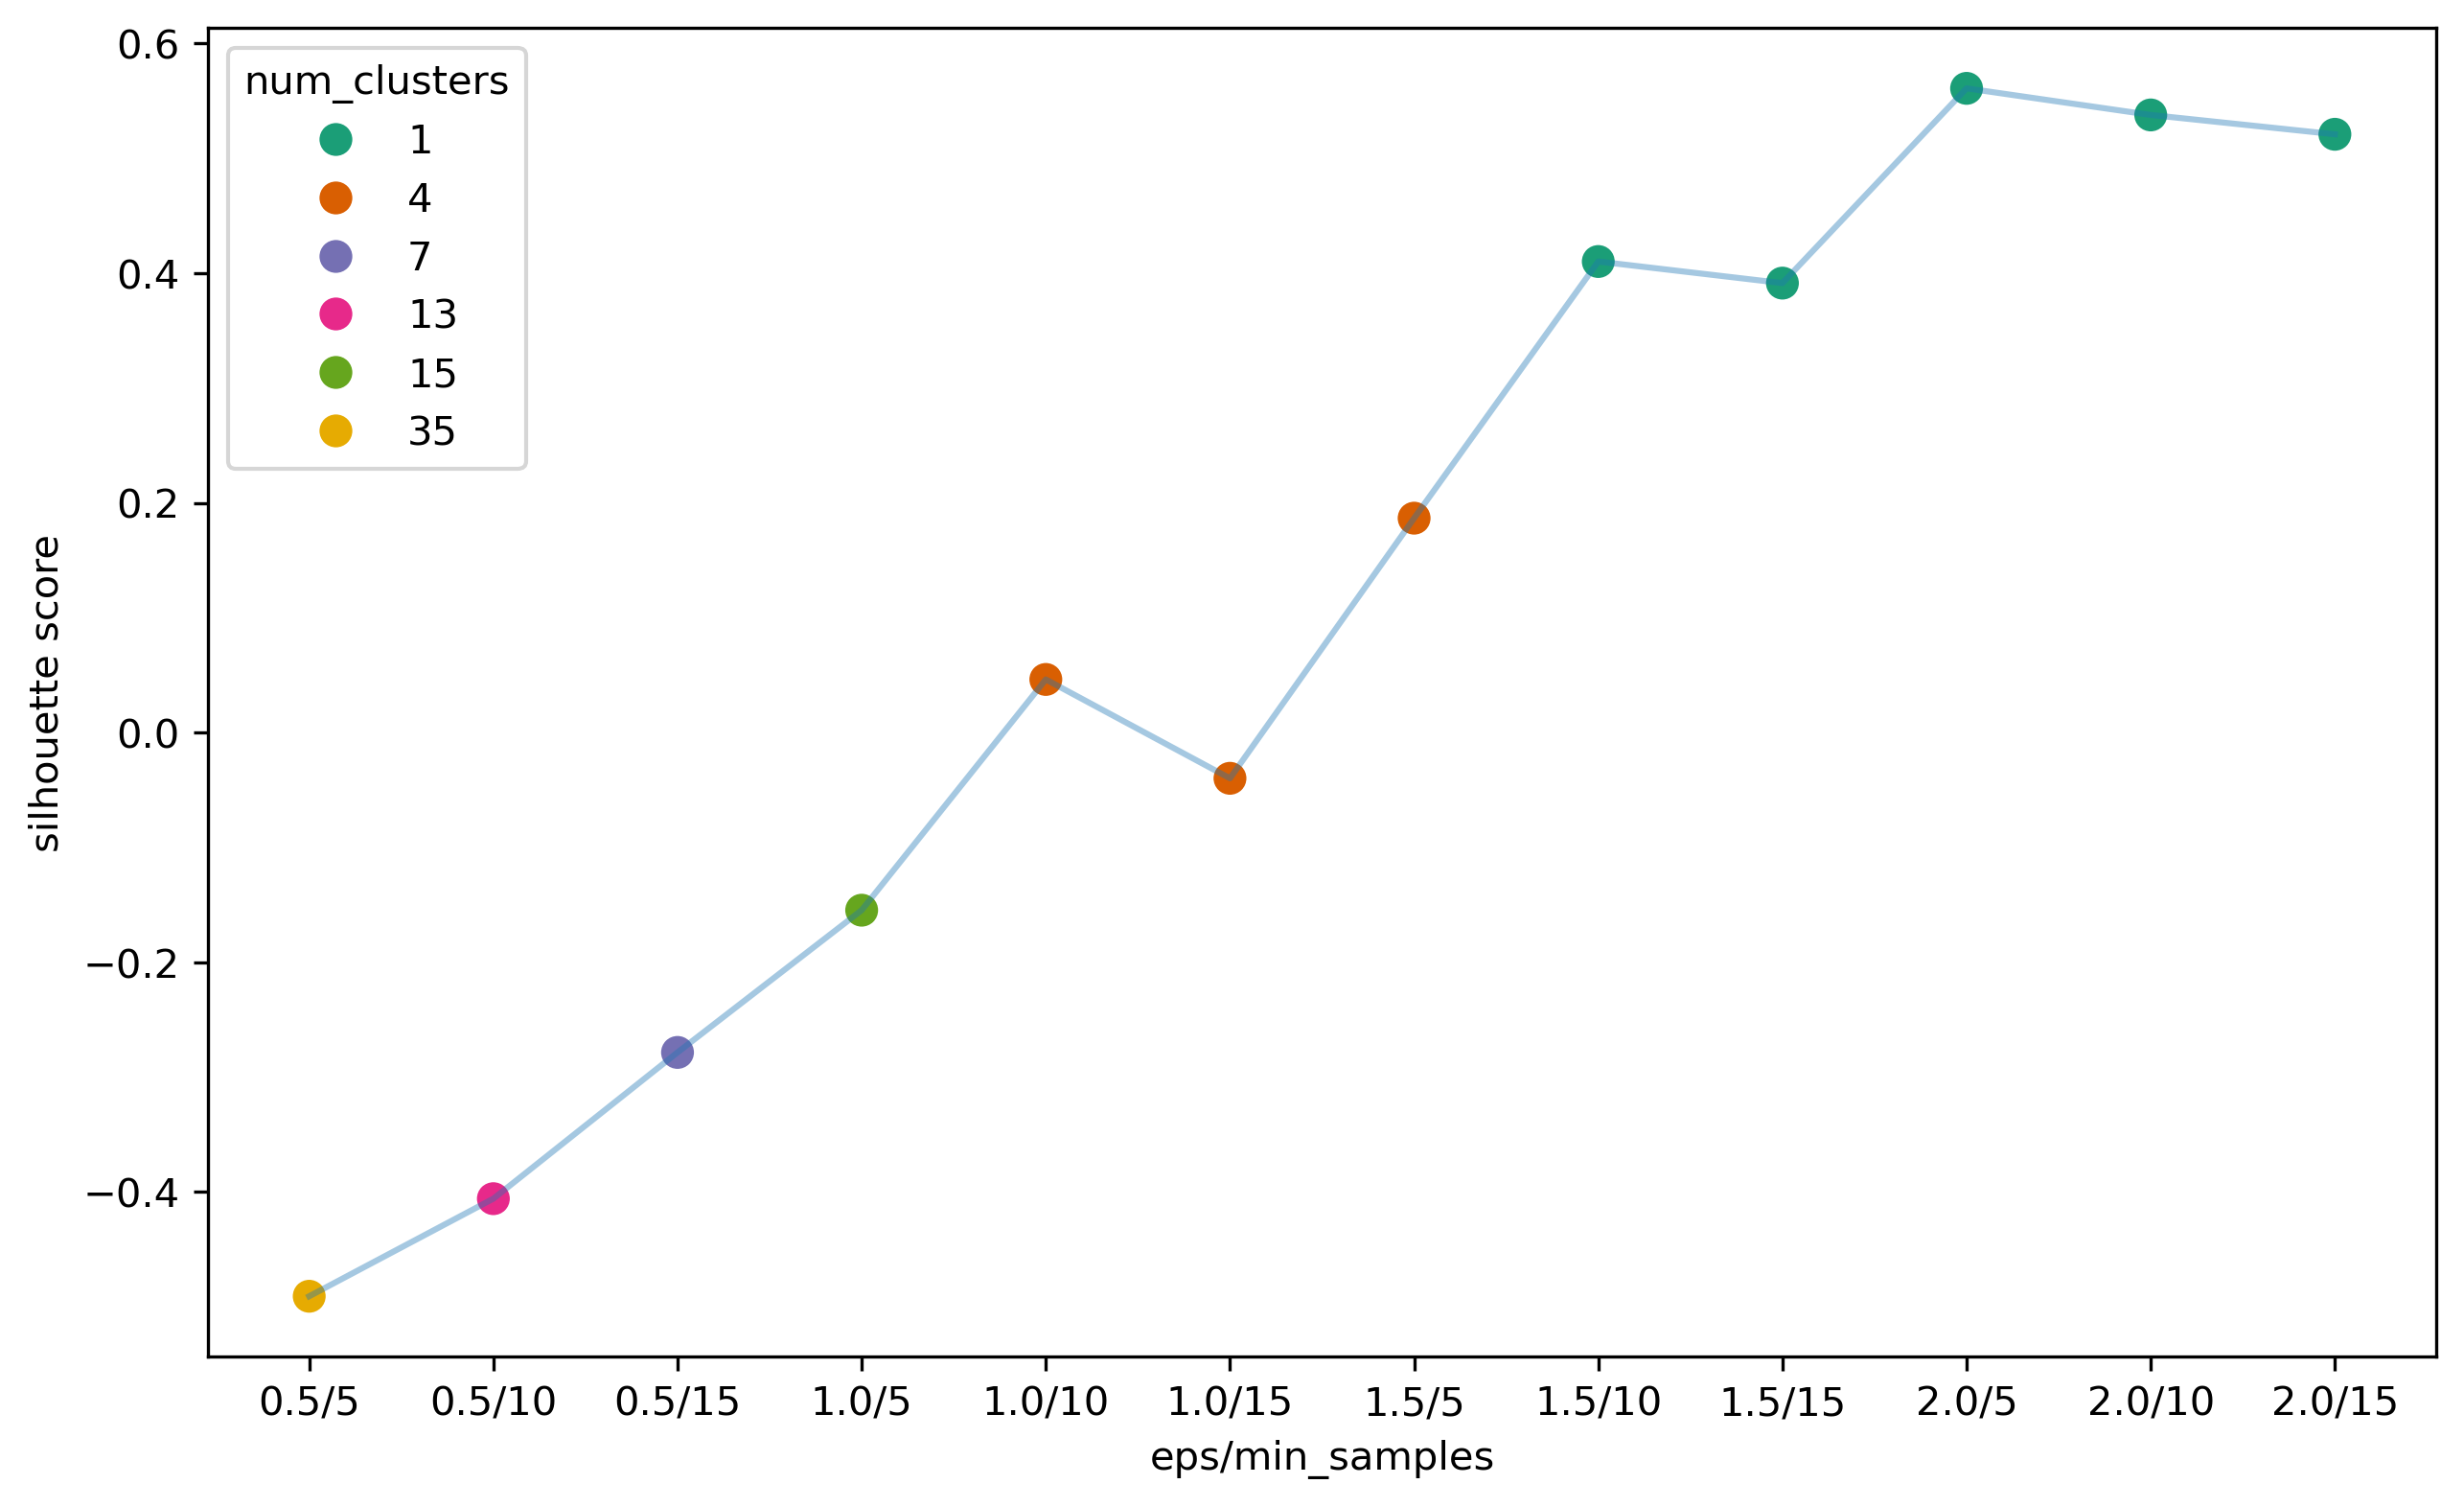

In [10]:
plt.figure(figsize=(10, 6), dpi=300)
a = sns.lineplot(data= index_n, x = index_n['eps/min_samples'], y=silhouette_dbscan, alpha=0.4, legend='auto')
a.legend(['silhouette score'], bbox_to_anchor=(0.96, 0.70), frameon=False)
plt.ylabel('silhouette score')
sns.scatterplot(data=index_n, x = index_n.index, y=silhouette_dbscan, hue=index_n['num_clusters'], palette='Dark2', s=80)

plt.show()

> Se seleccionó la combinación de 1.5 y 5 para los parámetros eps y min_samples dado que son los que producen un coeficiente de silueta mayor y agrupan los datos en más de un cluster.

In [11]:
dbscan2 = DBSCAN(eps=1.5, min_samples=5)
dbscan2_clustering = dbscan2.fit_predict(df_pca)

# Agrupamiento con hierarchical clustering

> Se generaron de 2 a 10 clusters usando clustering jerárquico y se compararon los resultados mediante el coeficiente de silueta.

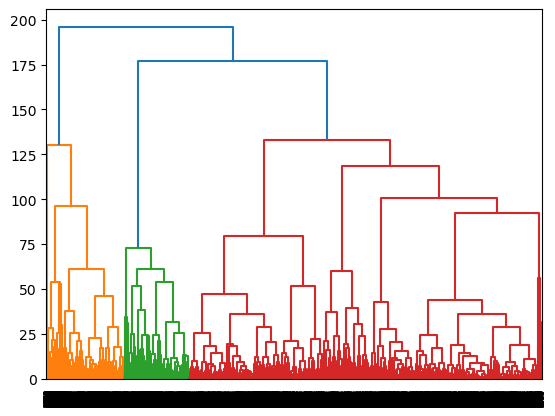

In [12]:
linkage_matrix = linkage(df_pca.values, 'ward')
dendro = sch.dendrogram(linkage_matrix)
plt.show()

In [13]:
def hie_clus(data):
    
    clusters_hie = []
    silhouette_hie = []

    for i in range(2, 9):
        clusters = fcluster(linkage_matrix, t=i, criterion='maxclust')
        clusters_hie.append(clusters)
        silhouette_hie.append(silhouette_score(data, clusters))

    return clusters_hie, silhouette_hie

clusters_hie, silhouette_hie = hie_clus(df_pca)

<function matplotlib.pyplot.show(close=None, block=None)>

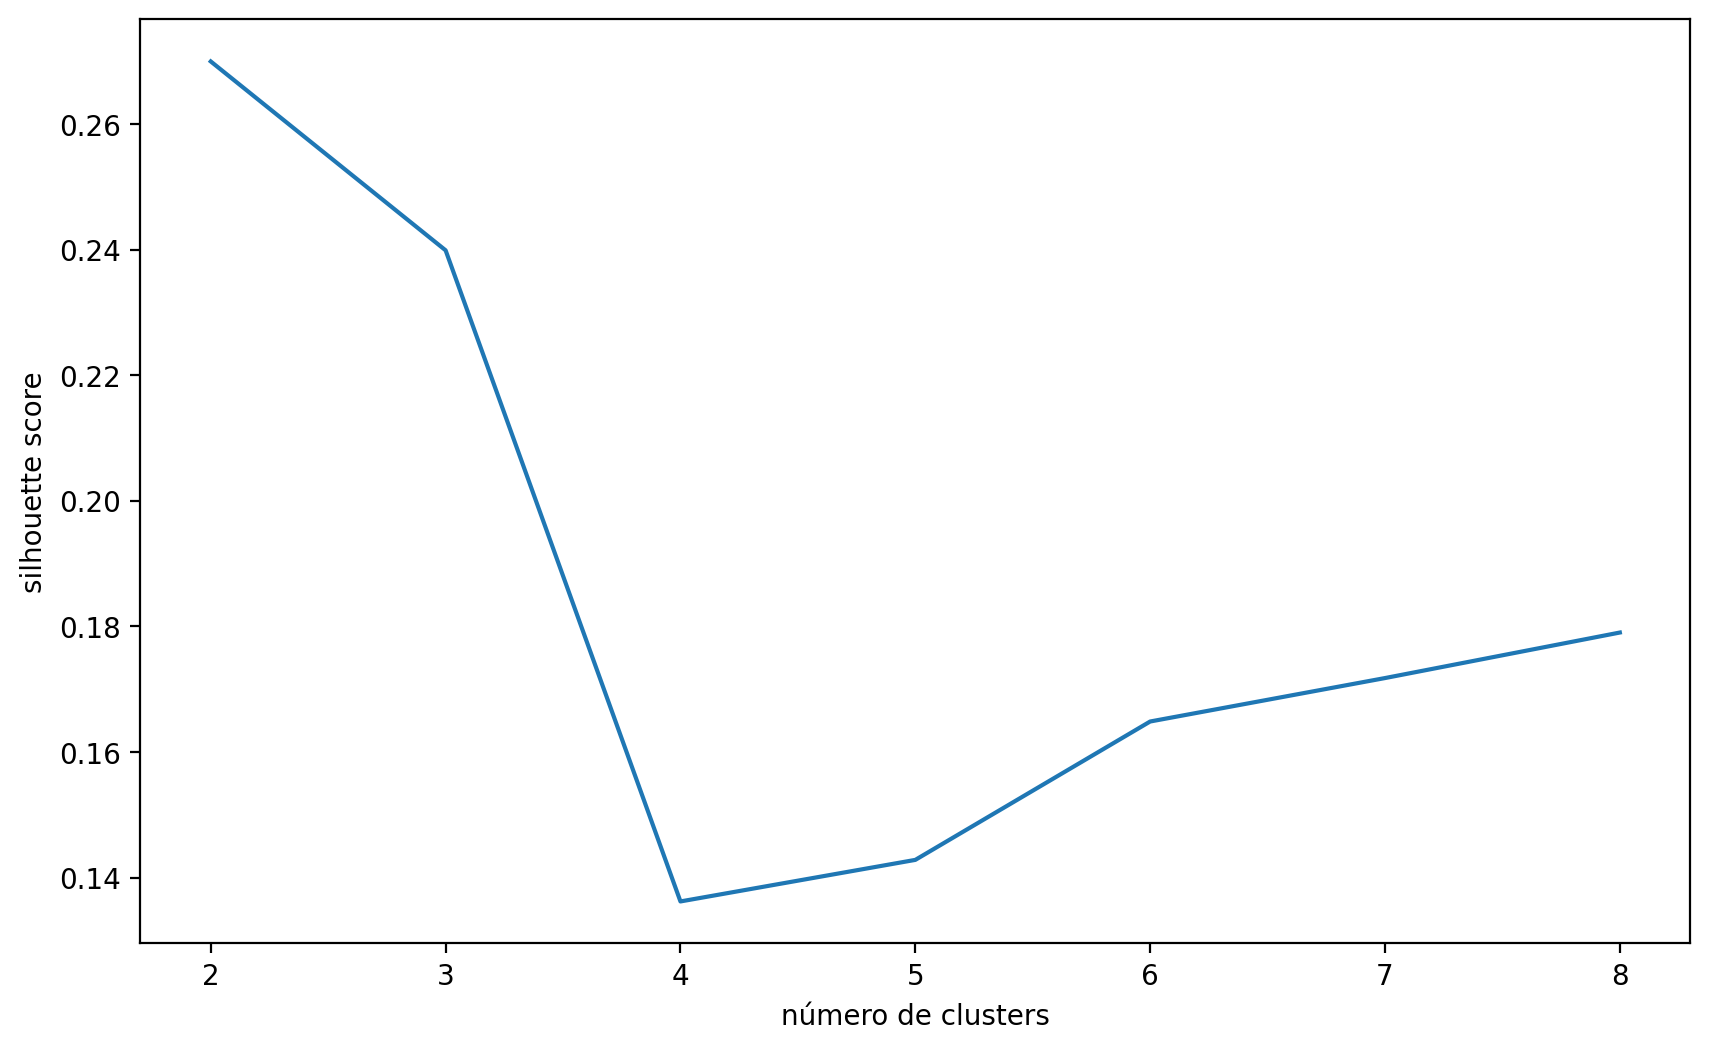

In [14]:
plt.figure(figsize=(10, 6), dpi=200)

sns.lineplot(x=range(2, 9), y=silhouette_hie)
plt.ylabel('silhouette score')
plt.xlabel('número de clusters')

plt.show

> De acuerdo con el coeficiente de silueta, el número optimo de clusters son 2, sin embargo 3 clusters produjo un coeficiente de silueta similar, por lo que ambas configuraciones se consideraron para la evaluación.

# Coeficiente de silueta de los tres métodos de agrupamiento

In [15]:
print("Coeficiente de silueta para Kmeans:", silhouette_score(df_pca, kmeans.labels_))
print("Coeficiente de silueta para DBSCAN:", silhouette_score(df_pca, dbscan2_clustering))
print("Coeficiente de silueta para HC (2 clusters):", silhouette_score(df_pca, clusters_hie[0]))
print("Coeficiente de silueta para HC (3 clusters):", silhouette_score(df_pca, clusters_hie[1]))

Coeficiente de silueta para Kmeans: 0.25860548481189216
Coeficiente de silueta para DBSCAN: 0.18669777045731104
Coeficiente de silueta para HC (2 clusters): 0.2700232430825149
Coeficiente de silueta para HC (3 clusters): 0.23992918749606376


> El clustering jerárquico fue el método que produjo el coeficiente de silueta más alto. A pesar de esto, se graficaron los resultados de todos los algoritmos de agrupamiento para realizar una comparación visual y seleccionar el modelo más adecuado.

# Exportación de las etiquetas producidas por los tres métodos a un archivo CSV

In [16]:
labels = pd.DataFrame(index=df.index)
labels['K-means clusters'] = kmeans.labels_
labels['DBSCAN clusters'] = dbscan2_clustering
labels['Hierarchical clustering 2 clusters'] = clusters_hie[0]
labels['Hierarchical clustering 3 clusters'] = clusters_hie[1]
labels.to_csv('../Data/scaled_PCA_labels.csv')